In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [74]:
import pandas as pd
import numpy as np
import gzip
import requests
import os

In [9]:
# Download data function
def download_data(url, name_to_save):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(name_to_save, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

In [19]:
# Download IMDB data and save it in the 'data' folder
os.makedirs('data', exist_ok=True)

download_data('https://datasets.imdbws.com/title.basics.tsv.gz', 'data/movie_basics.gz')
download_data('https://datasets.imdbws.com/title.ratings.tsv.gz', 'data/movie_ratings.gz')
download_data('https://datasets.imdbws.com/title.crew.tsv.gz', 'data/movie_crew.gz')
download_data('https://datasets.imdbws.com/name.basics.tsv.gz', 'data/names_basics.gz')

In [20]:
# Read Gzip TSV into dataframe function
def read_gzipped_tsv_to_dataframe(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        dataframe = pd.read_csv(file, sep='\t', low_memory=False)
    return dataframe

In [23]:
# Read data to dataframes
movie_basics_df = read_gzipped_tsv_to_dataframe('data/movie_basics.gz')
movie_ratings_df = read_gzipped_tsv_to_dataframe('data/movie_ratings.gz')
movie_crew_df = read_gzipped_tsv_to_dataframe('data/movie_crew.gz')
names_basics_df = read_gzipped_tsv_to_dataframe('data/names_basics.gz')

C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4292\3153905109.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(file, sep='\t')


In [58]:
# Basic info function

def generate_info(dataframes, names):
    for df, name in zip(dataframes, names):
        print(f"EDA for {name}")
        
        # Check for duplicate rows
        print(f"Number of duplicate rows: {df.duplicated().sum()}")
        
        # Print basic information
        print("\nBasic Information:")
        print(df.info())
        
        # Display the first 5 rows
        print("\nFirst 5 rows:")
        print(df.head())
        
        # Display the summary statistics
        print("\nSummary Statistics:")
        print(df.describe())


In [51]:
# Generate info for each df

dataframes = [movie_crew_df, movie_ratings_df, movie_basics_df, names_basics_df]
names = ['Movie Crew', 'Movie Ratings', 'Movie Basics', 'Names Basics']

generate_info(dataframes, names)

EDA for Movie Crew
Number of duplicate rows: 0

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9753704 entries, 0 to 9753703
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   tconst     object
 1   directors  object
 2   writers    object
dtypes: object(3)
memory usage: 223.2+ MB
None

First 5 rows:
      tconst  directors writers
0  tt0000001  nm0005690      \N
1  tt0000002  nm0721526      \N
2  tt0000003  nm0721526      \N
3  tt0000004  nm0721526      \N
4  tt0000005  nm0005690      \N

Summary Statistics:
           tconst directors  writers
count     9753704   9753704  9753704
unique    9753704    868135  1254557
top     tt0000001        \N       \N
freq            1   4151206  4718589
EDA for Movie Ratings
Number of duplicate rows: 0

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298304 entries, 0 to 1298303
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------       

In [ ]:
# Deal with N/a Values

movie_basics_df.dropna(inplace=True) # drow n/a rows
names_basics_df.drop(['primaryProfession'], axis=1, inplace=True) #drop useless column
names_basics_df.dropna(inplace=True) # drow n/a rows

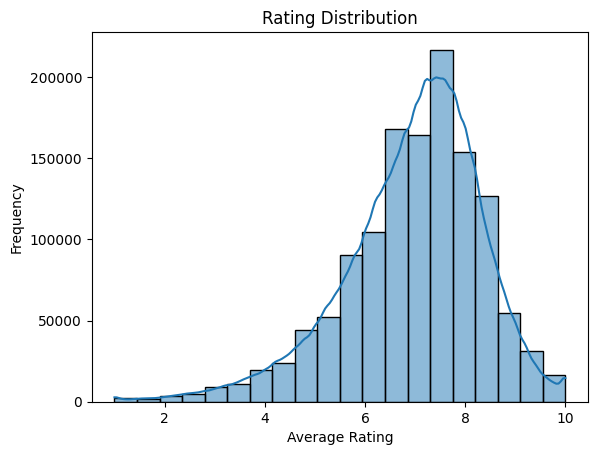

In [53]:
# Lets see the distribution for all ratings

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=movie_ratings_df, x='averageRating', bins=20, kde=True)
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

In [54]:
# lets combine the dataframes to do some more interesting analysis

temp_df1 = movie_basics_df.merge(movie_ratings_df, on='tconst', how='inner') # i do an inner join to not have to deal with n/a values
temp_df2 = temp_df1.merge(movie_crew_df, on='tconst', how='inner')
merged_data = temp_df2.merge(names_basics_df, left_on='directors', right_on='nconst', how='inner')

# drop columns that dont make sense
merged_data = merged_data.drop(['writers', 'birthYear', 'knownForTitles'], axis=1)


In [60]:
generate_info([merged_data], ['All Data'])

EDA for All Data
Number of duplicate rows: 0

Basic Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 927342 entries, 0 to 927341
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          927342 non-null  object 
 1   titleType       927342 non-null  object 
 2   primaryTitle    927342 non-null  object 
 3   originalTitle   927342 non-null  object 
 4   isAdult         927342 non-null  object 
 5   startYear       927342 non-null  object 
 6   endYear         927342 non-null  object 
 7   runtimeMinutes  927342 non-null  object 
 8   genres          927342 non-null  object 
 9   averageRating   927342 non-null  float64
 10  numVotes        927342 non-null  int64  
 11  directors       927342 non-null  object 
 12  nconst          927342 non-null  object 
 13  primaryName     927342 non-null  object 
 14  deathYear       927342 non-null  object 
dtypes: float64(1), int64(1), object(13)
m

In [62]:
merged_data.titleType.value_counts()

tvEpisode       404660
movie           259932
short           125567
tvMovie          43111
tvSeries         36080
video            34943
tvMiniSeries      9412
tvSpecial         6823
videoGame         5125
tvShort           1689
Name: titleType, dtype: int64

In [67]:
movies_df = merged_data[merged_data['titleType'].isin(['movie', 'tvMovie'])]  # lets only look at movies for now
movies_df # 300k entries remain



,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,nconst,primaryName,deathYear
168,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,204,nm0085156,nm0085156,Alexander Black,1940
947,tt0003365,movie,Shadows of the Moulin Rouge,Shadows of the Moulin Rouge,0,1913,\N,60,Drama,4.6,24,nm0349785,nm0349785,Alice Guy,1968
950,tt0007614,movie,The Adventurer,The Adventurer,0,1917,\N,50,Drama,6.5,25,nm0349785,nm0349785,Alice Guy,1968
951,tt0007885,movie,The Empress,The Empress,0,1917,\N,50,Drama,5.2,13,nm0349785,nm0349785,Alice Guy,1968
952,tt0009128,movie,The Great Adventure,The Great Adventure,0,1918,\N,50,Drama,6.5,23,nm0349785,nm0349785,Alice Guy,1968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927334,tt9914662,movie,Wien is 't Hof van Commerce,Wien is 't Hof van Commerce,0,2018,\N,\N,Comedy,7.4,6,nm10537404,nm10537404,Kristof Michiels,\N
927337,tt9915790,movie,Bobbyr Bondhura,Bobbyr Bondhura,0,2019,\N,106,Family,7.2,39,nm10538030,nm10538030,Sudipa Chatterjee,\N
927338,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019,\N,97,"Comedy,Drama,Fantasy",7.3,8,nm8063415,nm8063415,Hideki Kiyota,\N
927340,tt9916170,movie,The Rehearsal,O Ensaio,0,2019,\N,51,Drama,7.0,7,nm5412267,nm5412267,Tamar Guimaraes,\N


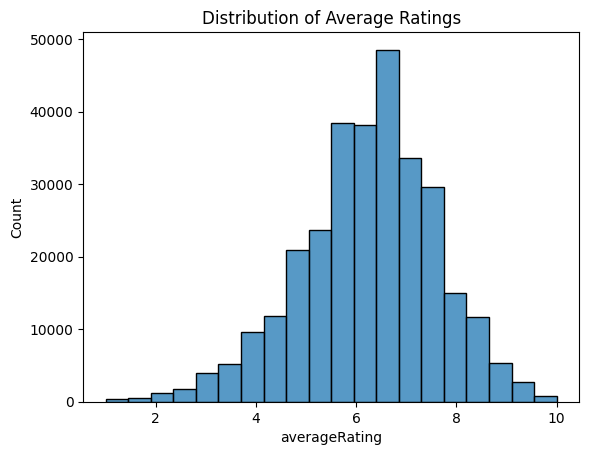

In [68]:
sns.histplot(data=movies_df, x='averageRating', bins=20)
plt.title('Distribution of Average Ratings')
plt.show()  # movie ratings on

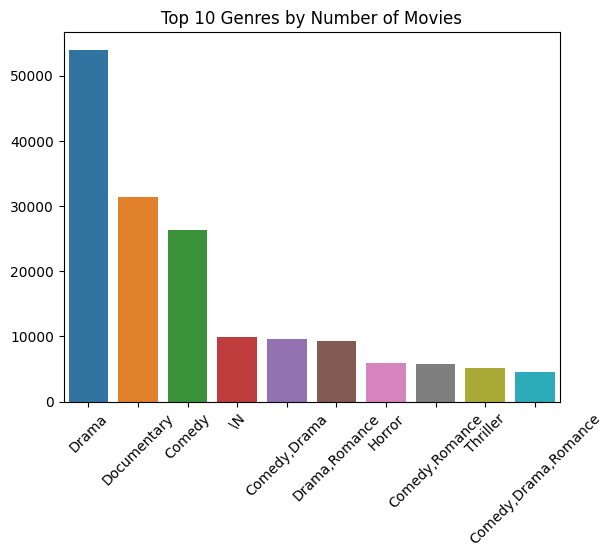

In [70]:
top_genres = movies_df['genres'].value_counts().head(10)
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 10 Genres by Number of Movies')
plt.xticks(rotation=45)
plt.show()

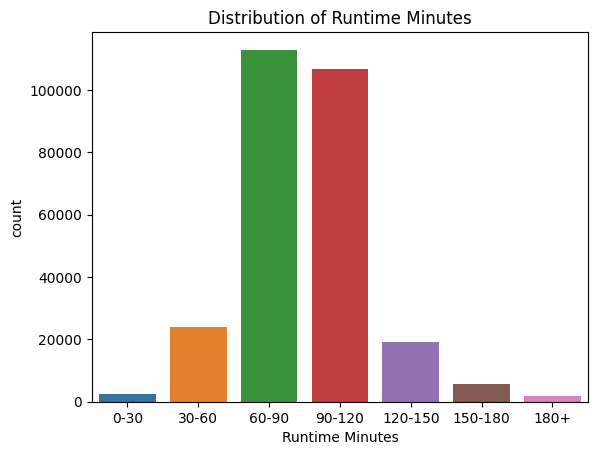

In [76]:
# Filter out the '\\N' values
runtime_minutes_filtered = movies_df[movies_df['runtimeMinutes'] != '\\N'].copy()

# Convert the 'runtimeMinutes' column to numeric values
runtime_minutes_filtered['runtimeMinutes'] = pd.to_numeric(runtime_minutes_filtered['runtimeMinutes'])

# Create bins for runtime minutes
runtime_minutes_filtered['runtimeBins'] = pd.cut(runtime_minutes_filtered['runtimeMinutes'], bins=[0, 30, 60, 90, 120, 150, 180, np.inf], labels=['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180+'])

# Plot the histogram
sns.countplot(data=runtime_minutes_filtered, x='runtimeBins', order=['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180+'])
plt.title('Distribution of Runtime Minutes')
plt.xlabel('Runtime Minutes')
plt.show()

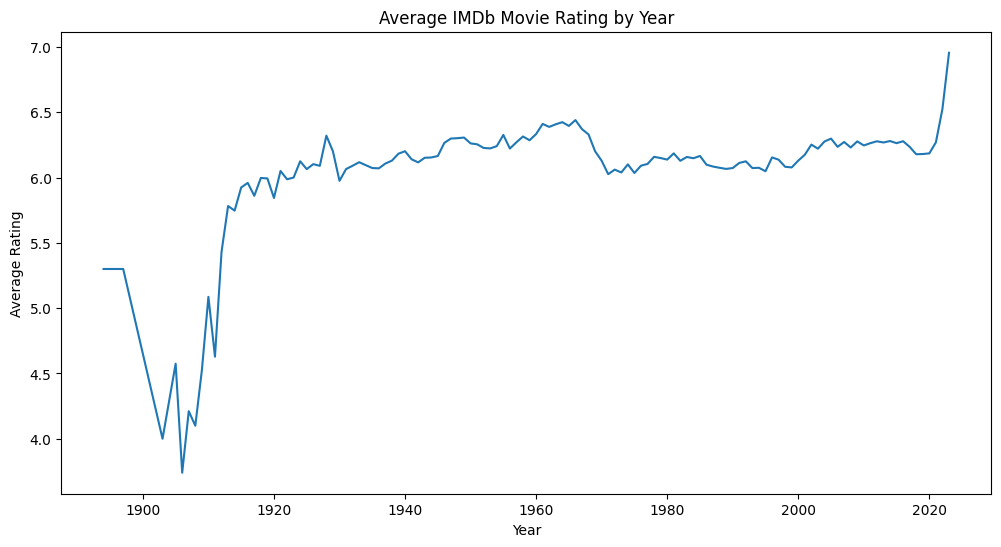

In [84]:
# Filter out the '\\N' values in 'startYear' column
year_filtered = movies_df[movies_df['startYear'] != '\\N'].copy()

# Convert the 'startYear' column to numeric values
year_filtered['startYear'] = pd.to_numeric(year_filtered['startYear'])

# Group by 'startYear' and calculate the mean rating for each group
average_rating_by_year = year_filtered.groupby('startYear')['averageRating'].mean().reset_index()

# Plot the average rating by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_rating_by_year, x='startYear', y='averageRating')
plt.title('Average IMDb Movie Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

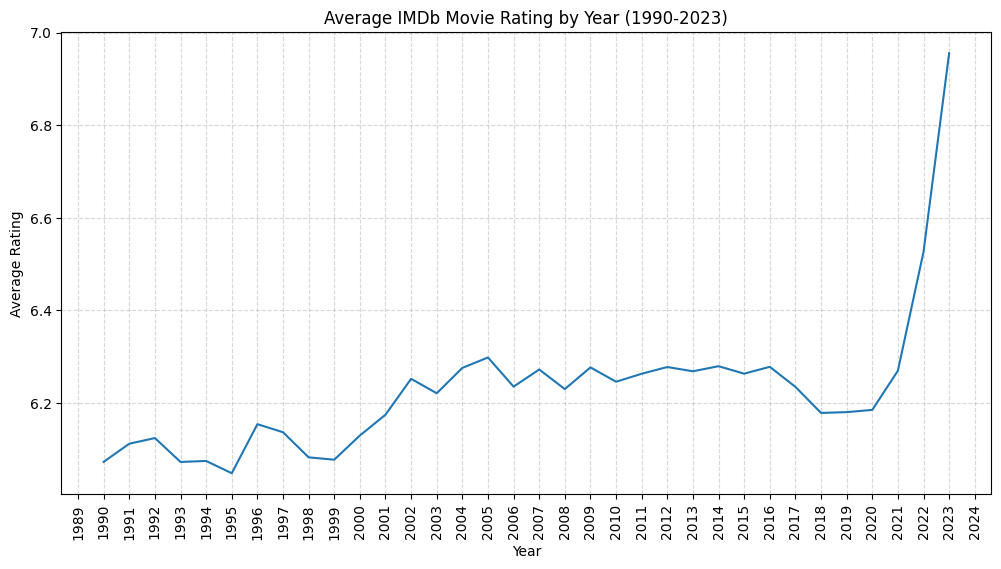

Seems that movie rating tends to decrease with time


In [89]:
# Lets zoom in the data for years between 1990 and 2023
import matplotlib.ticker as ticker

# Filter the data for years between 1990 and 2023
average_rating_by_year_filtered = average_rating_by_year[(average_rating_by_year['startYear'] >= 1990) & (average_rating_by_year['startYear'] <= 2023)]

# Plot the average rating by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_rating_by_year_filtered, x='startYear', y='averageRating')
plt.title('Average IMDb Movie Rating by Year (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Average Rating')

# Add gridlines
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Rotate year labels
plt.xticks(rotation=90)

# Set x-axis ticks to show every year
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
print('Seems that movie rating tends to decrease with time')

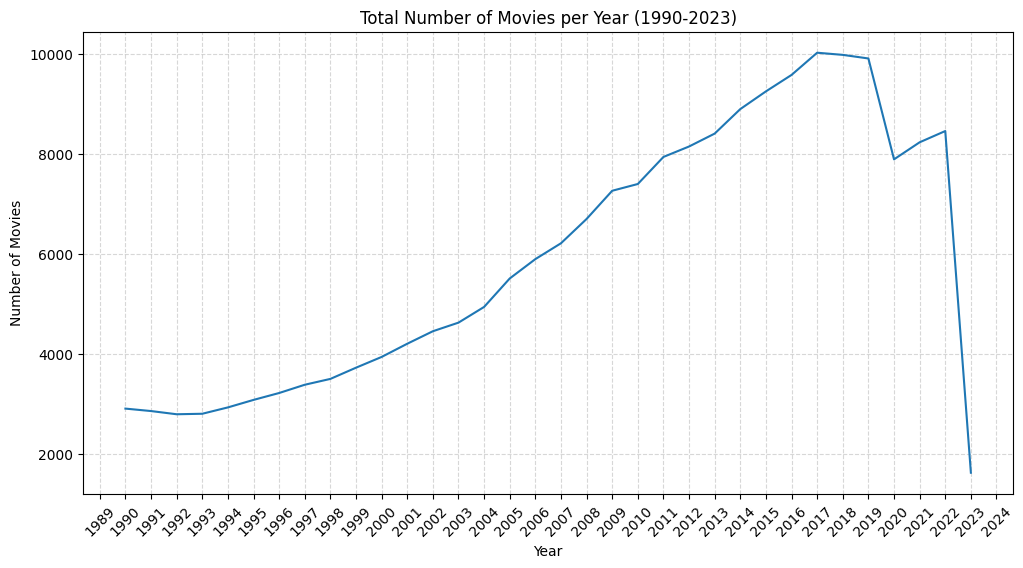

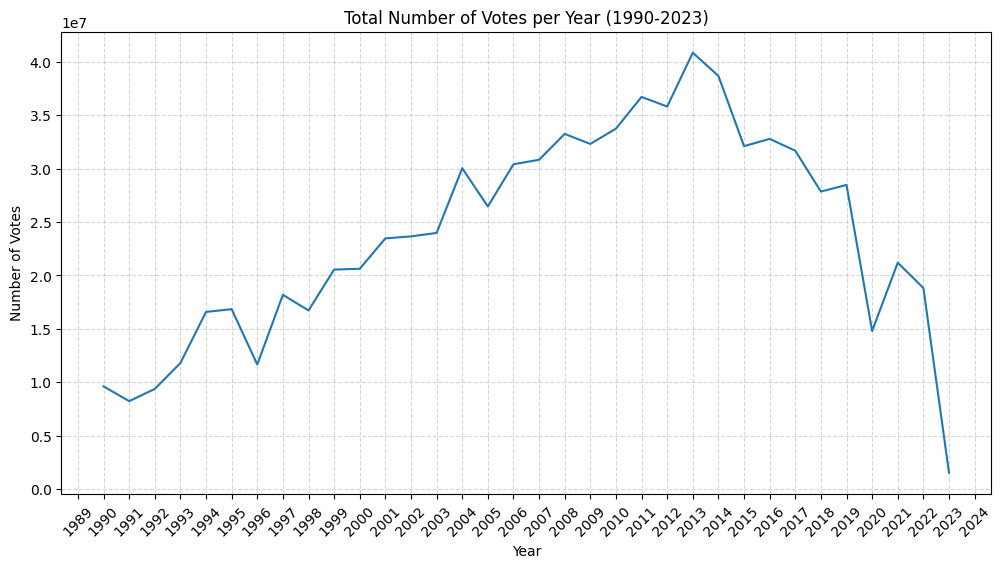

In [87]:
# Aggregate data by year
year_filtered = movies_df[movies_df['startYear'] != '\\N'].copy()

# Convert the 'startYear' column to numeric values
year_filtered['startYear'] = pd.to_numeric(year_filtered['startYear'])


movies_per_year = year_filtered[(year_filtered['startYear'] >= 1990) & (year_filtered['startYear'] <= 2023)].groupby('startYear').agg({'tconst': 'count', 'numVotes': 'sum'}).reset_index()

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the total number of movies per year
sns.lineplot(data=movies_per_year, x='startYear', y='tconst')
plt.title('Total Number of Movies per Year (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Add gridlines
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Rotate year labels
plt.xticks(rotation=45)

# Set x-axis ticks to show every year
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the total number of votes per year
sns.lineplot(data=movies_per_year, x='startYear', y='numVotes')
plt.title('Total Number of Votes per Year (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Votes')

# Add gridlines
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Rotate year labels
plt.xticks(rotation=45)

# Set x-axis ticks to show every year
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [90]:
# there is a problem with the genres column, all gendres for each movie are added in 1 column, lets 1-hot encode the gendres so we can work with them.
movies_df['genres'] = movies_df['genres'].str.split(',').copy()
genre_dummies = pd.get_dummies(movies_df['genres'].apply(pd.Series).stack(), prefix='genre').sum(level=0)
movies_df_encoded = pd.concat([movies_df, genre_dummies], axis=1)
movies_df_encoded = movies_df_encoded.drop('genres', axis=1)
movies_df_encoded.head()

C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4292\1327102645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['genres'] = movies_df['genres'].str.split(',')
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4292\1327102645.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  genre_dummies = pd.get_dummies(movies_df['genres'].apply(pd.Series).stack(), prefix='genre').sum(level=0)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western,genre_\N
168,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,5.3,204,...,0,1,0,0,0,0,0,0,0,0
947,tt0003365,movie,Shadows of the Moulin Rouge,Shadows of the Moulin Rouge,0,1913,\N,60,4.6,24,...,0,0,0,0,0,0,0,0,0,0
950,tt0007614,movie,The Adventurer,The Adventurer,0,1917,\N,50,6.5,25,...,0,0,0,0,0,0,0,0,0,0
951,tt0007885,movie,The Empress,The Empress,0,1917,\N,50,5.2,13,...,0,0,0,0,0,0,0,0,0,0
952,tt0009128,movie,The Great Adventure,The Great Adventure,0,1918,\N,50,6.5,23,...,0,0,0,0,0,0,0,0,0,0


In [109]:
genre_columns = [col for col in movies_df_encoded.columns if col.startswith('genre_')]
movies_df_encoded.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'averageRating', 'numVotes',
       'directors', 'nconst', 'primaryName', 'deathYear', 'genre_Action',
       'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
       'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Game-Show',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Musical',
       'genre_Mystery', 'genre_News', 'genre_Reality-TV', 'genre_Romance',
       'genre_Sci-Fi', 'genre_Short', 'genre_Sport', 'genre_Talk-Show',
       'genre_Thriller', 'genre_War', 'genre_Western', 'genre_\N'],
      dtype='object')

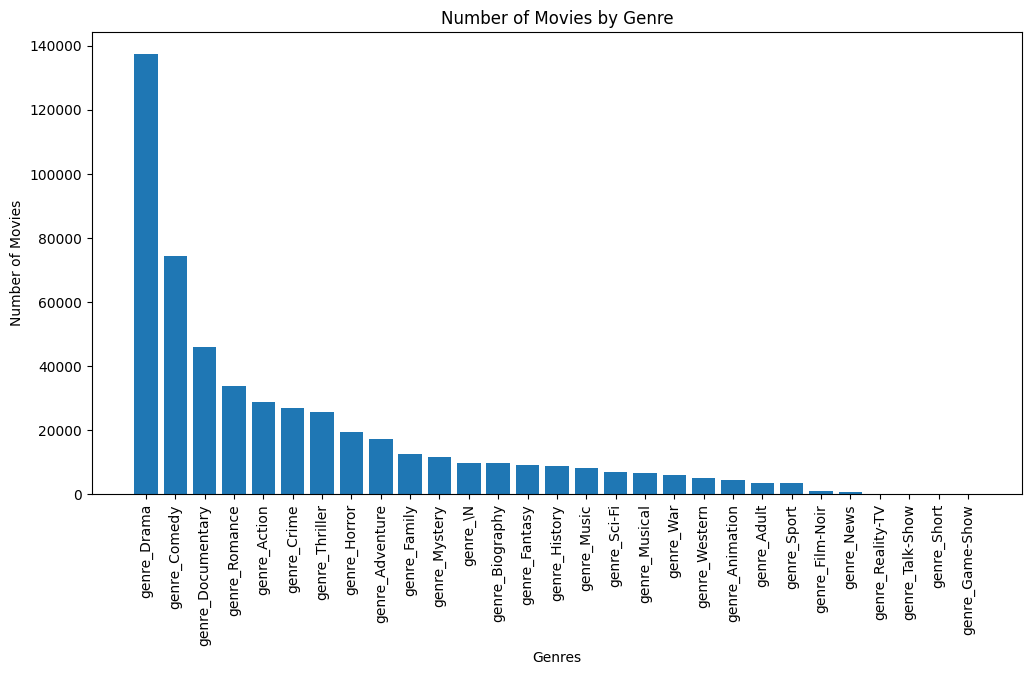

In [94]:
genre_columns = [col for col in movies_df_encoded.columns if col.startswith('genre_')]
genre_counts = movies_df_encoded[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))  
plt.bar(genre_counts.index, genre_counts.values)

# Set the title and labels
plt.title('Number of Movies by Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')

plt.xticks(rotation=90)

# Show the plot
plt.show()

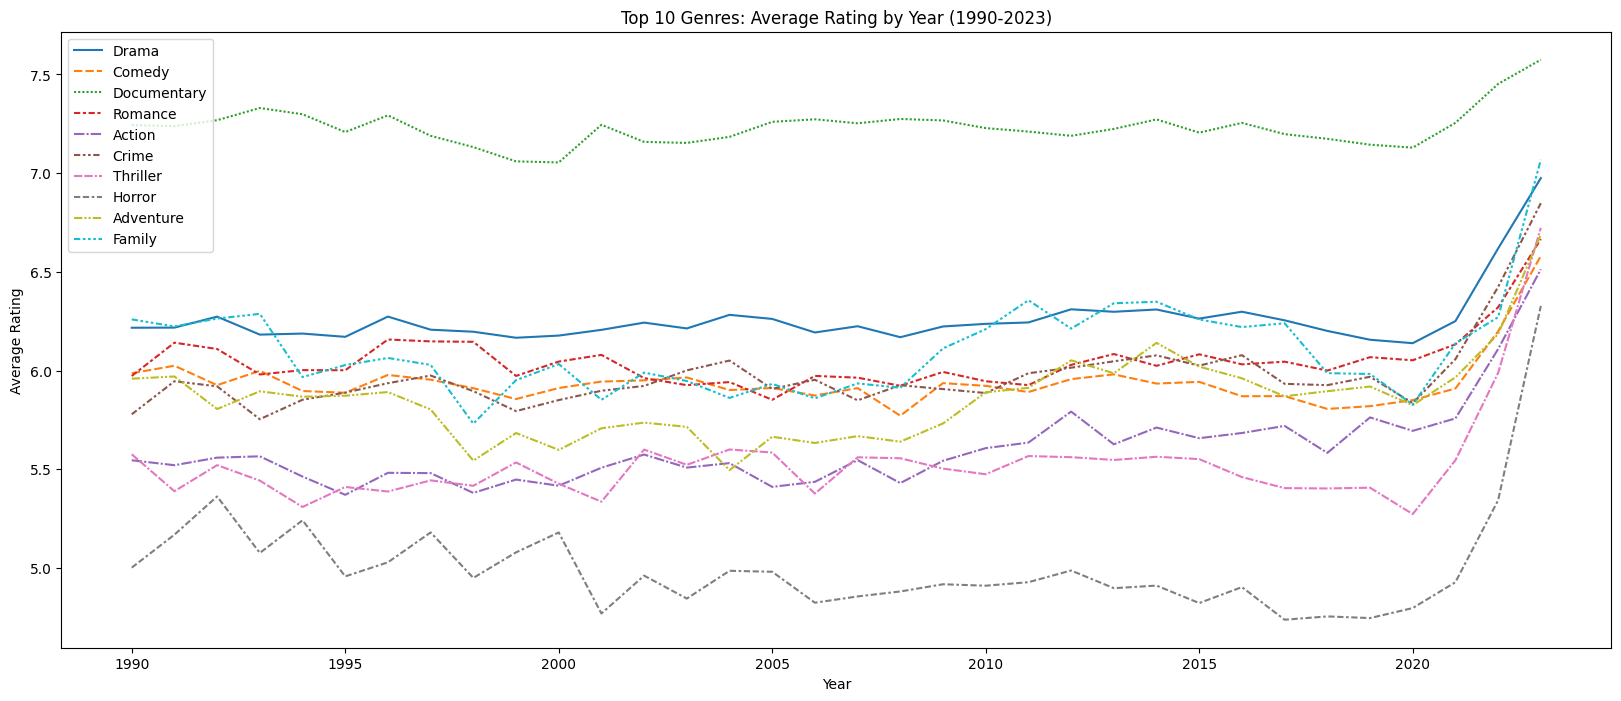

Documentaries appear to be much higher rated on average


In [108]:
# Get the top 10 genres by count
top_10_genres = genre_counts.head(10).index

# Remove 'genre_' prefix from genre names
top_10_genres = [genre.replace('genre_', '') for genre in top_10_genres]

year_filtered = movies_df_encoded[movies_df_encoded['startYear'] != '\\N'].copy()

# Convert the 'startYear' column to numeric values
year_filtered['startYear'] = pd.to_numeric(year_filtered['startYear'])

# Filter the dataframe by years (1990-2023)
filtered_years = year_filtered[(year_filtered['startYear'] >= 1990) & (year_filtered['startYear'] <= 2023)]

# Calculate the average rating per genre per year
genre_avg_ratings = []
for genre in top_10_genres:
    genre_avg_ratings.append(
        filtered_years[filtered_years[f'genre_{genre}'] == 1].groupby('startYear')['averageRating'].mean()
    )

# Concatenate the average ratings per year per genre
genre_avg_ratings_df = pd.concat(genre_avg_ratings, axis=1)
genre_avg_ratings_df.columns = top_10_genres

# Plot the average rating per genre per year
plt.figure(figsize=(20, 8))
sns.lineplot(data=genre_avg_ratings_df)

# Set the title and labels
plt.title('Top 10 Genres: Average Rating by Year (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Average Rating')

# Show the plot
plt.show()
print('Documentaries appear to be much higher rated on average')

C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4292\2735973403.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['startYear'] = genre_data['startYear'].astype(int)


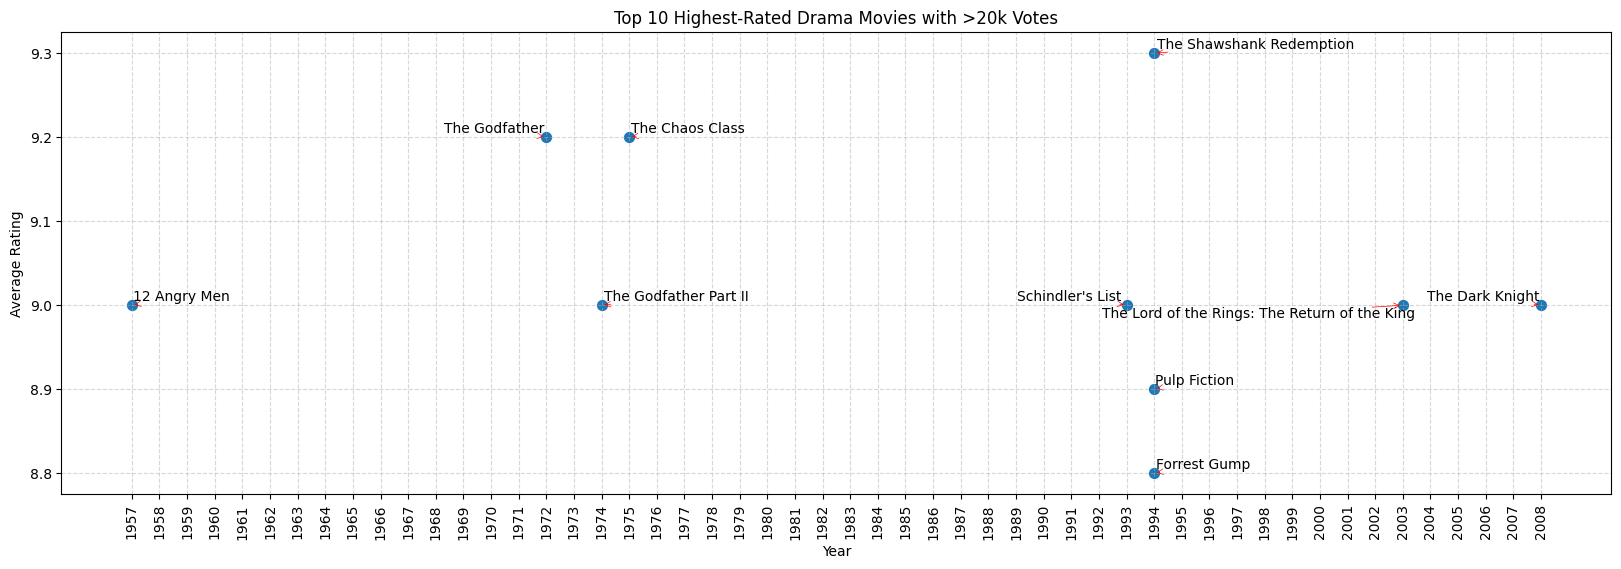

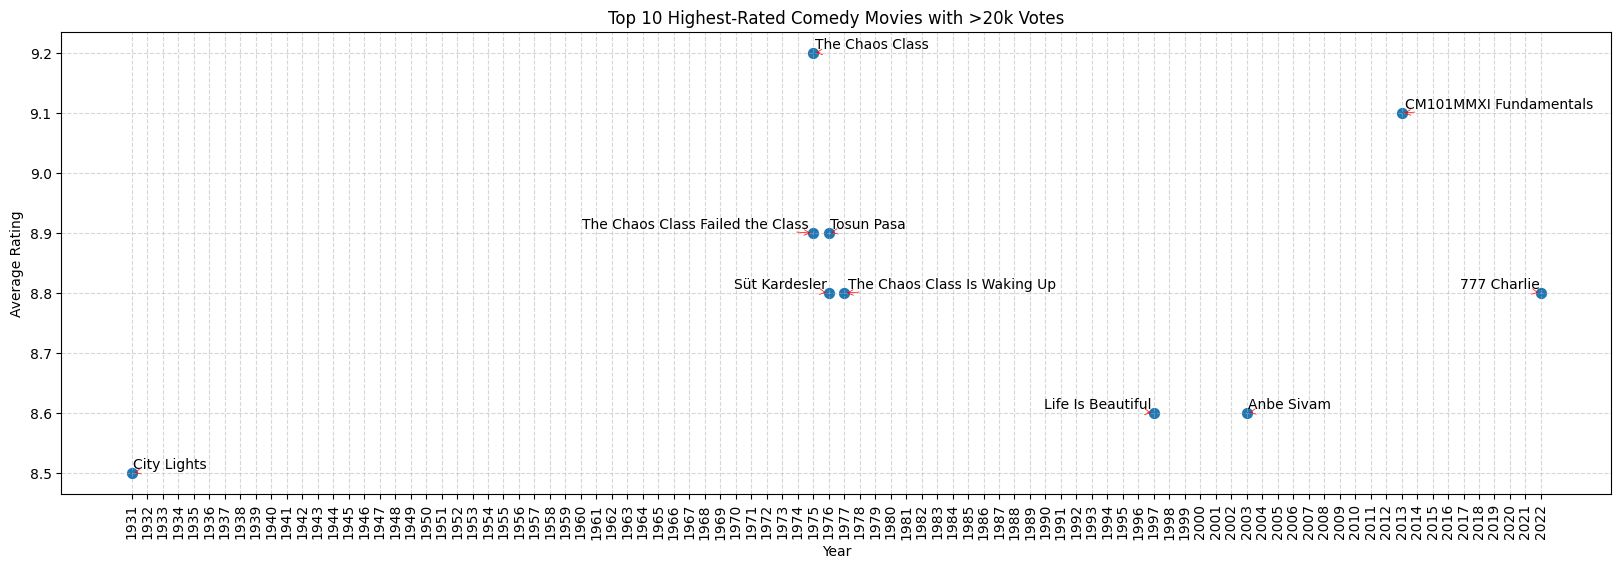

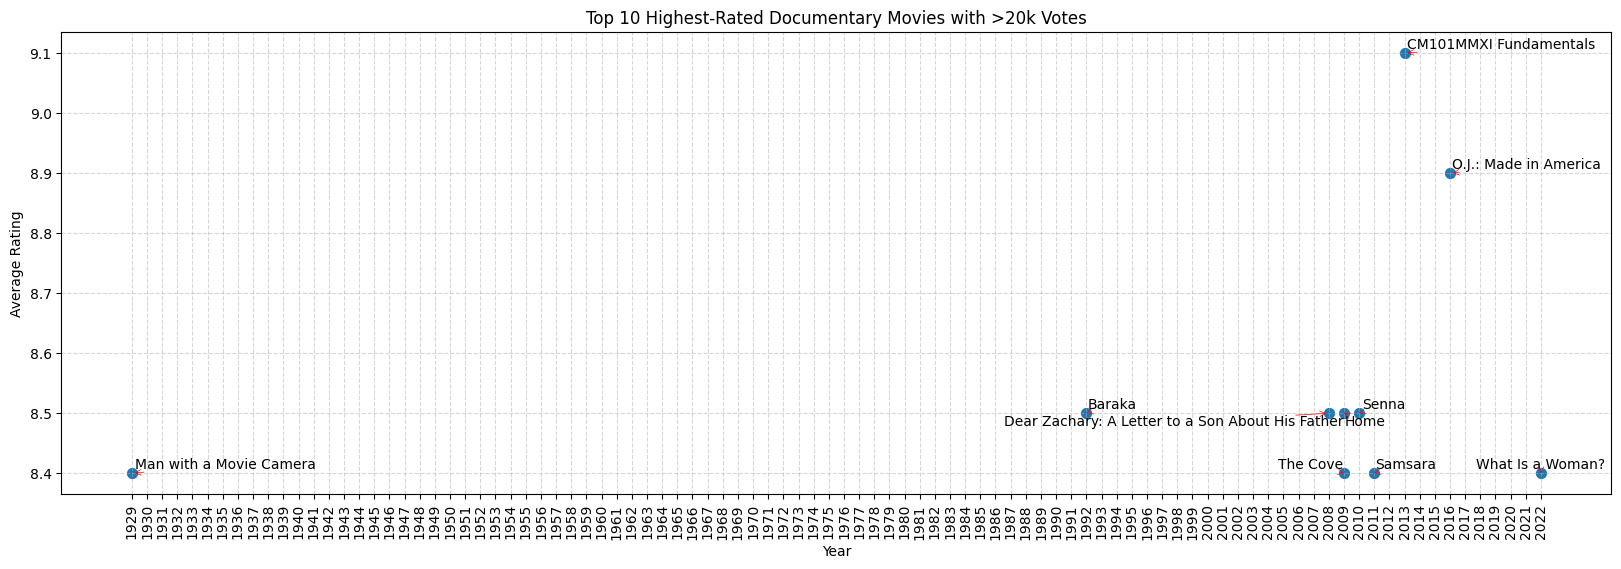

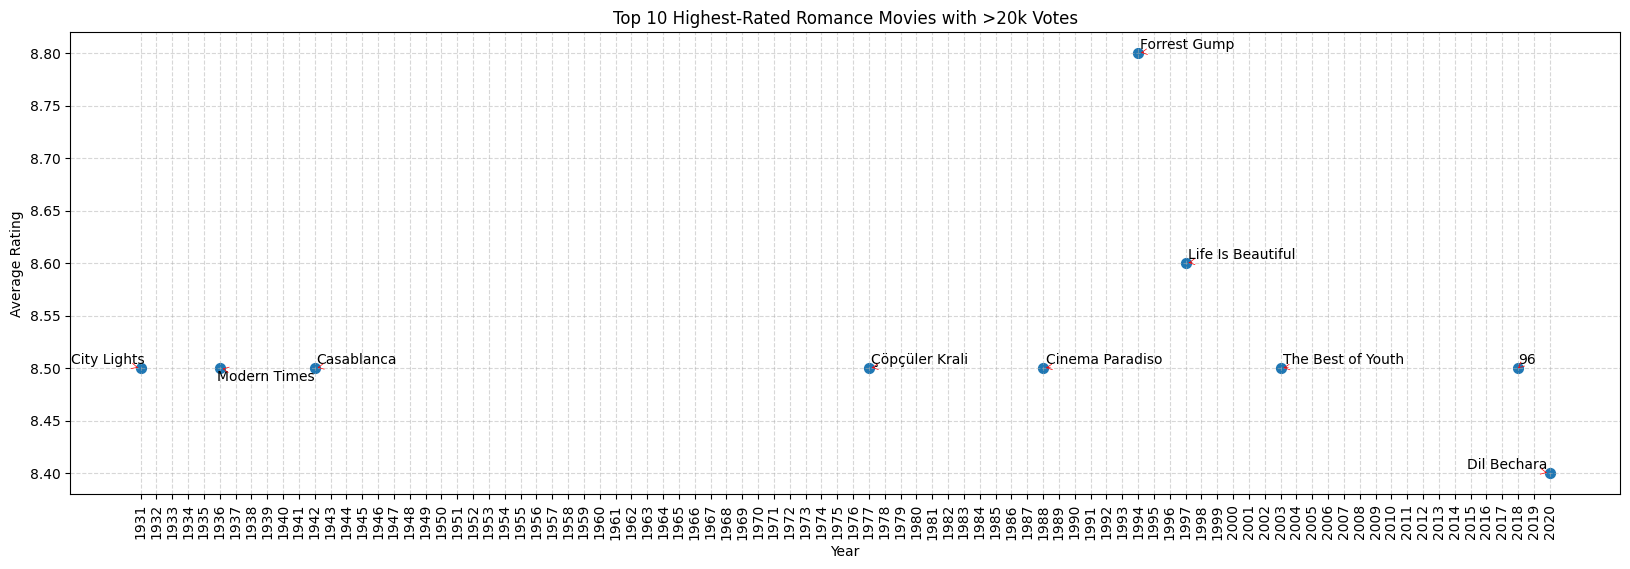

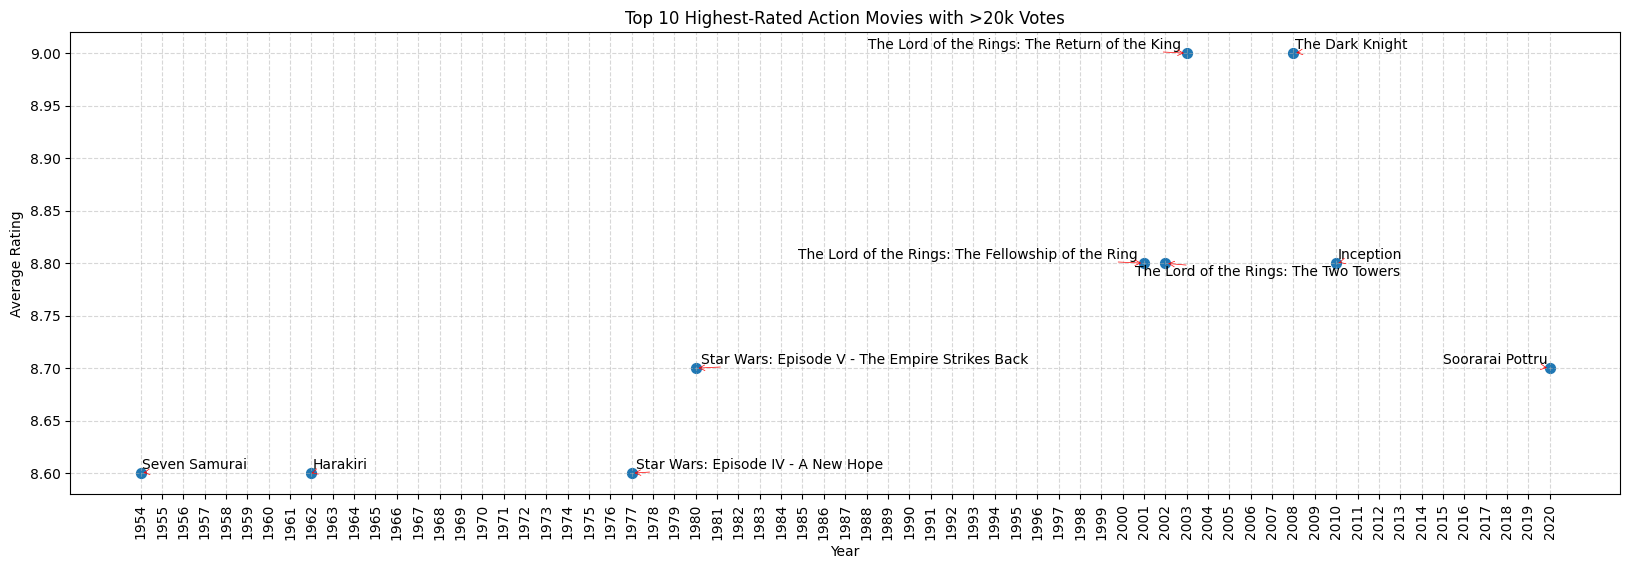

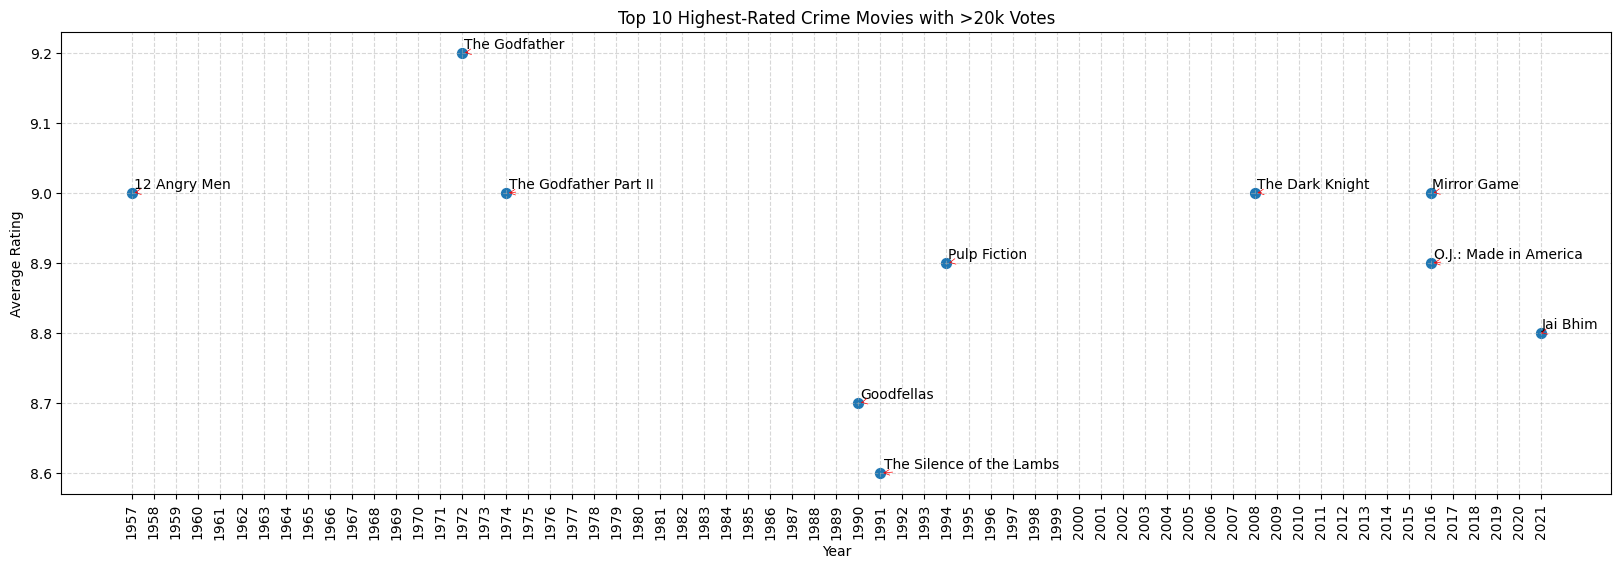

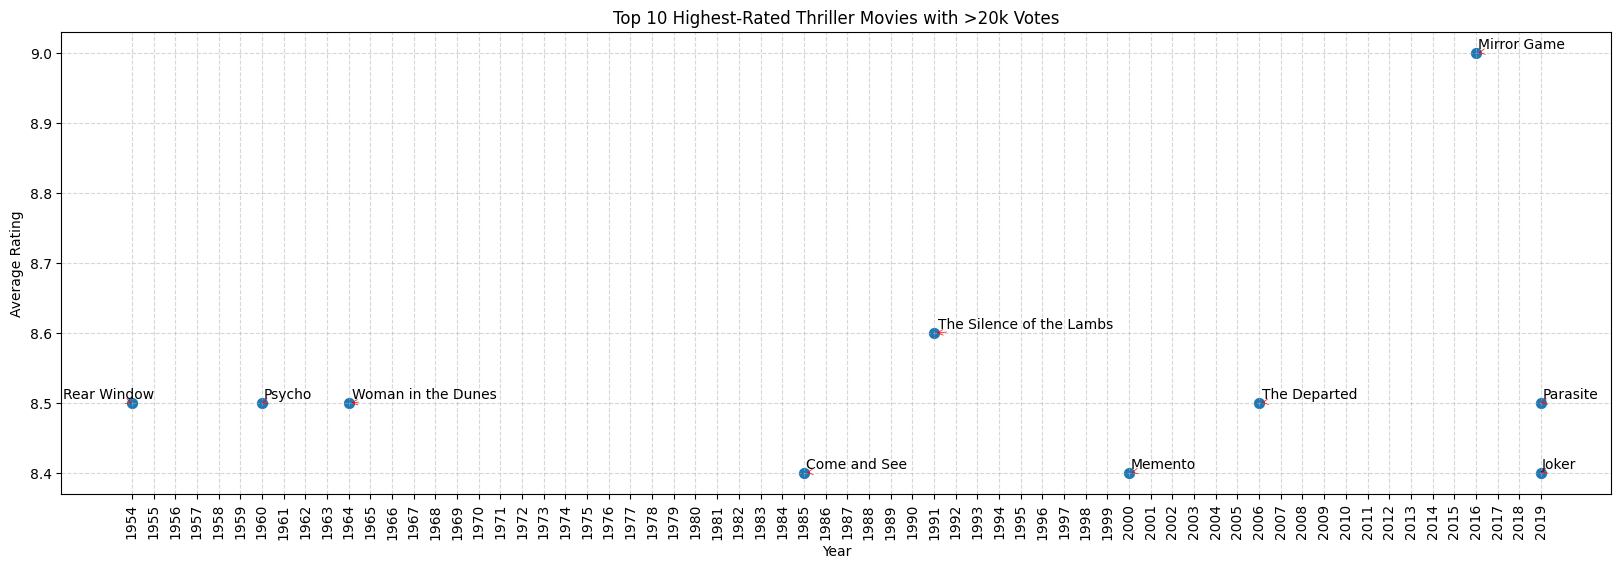

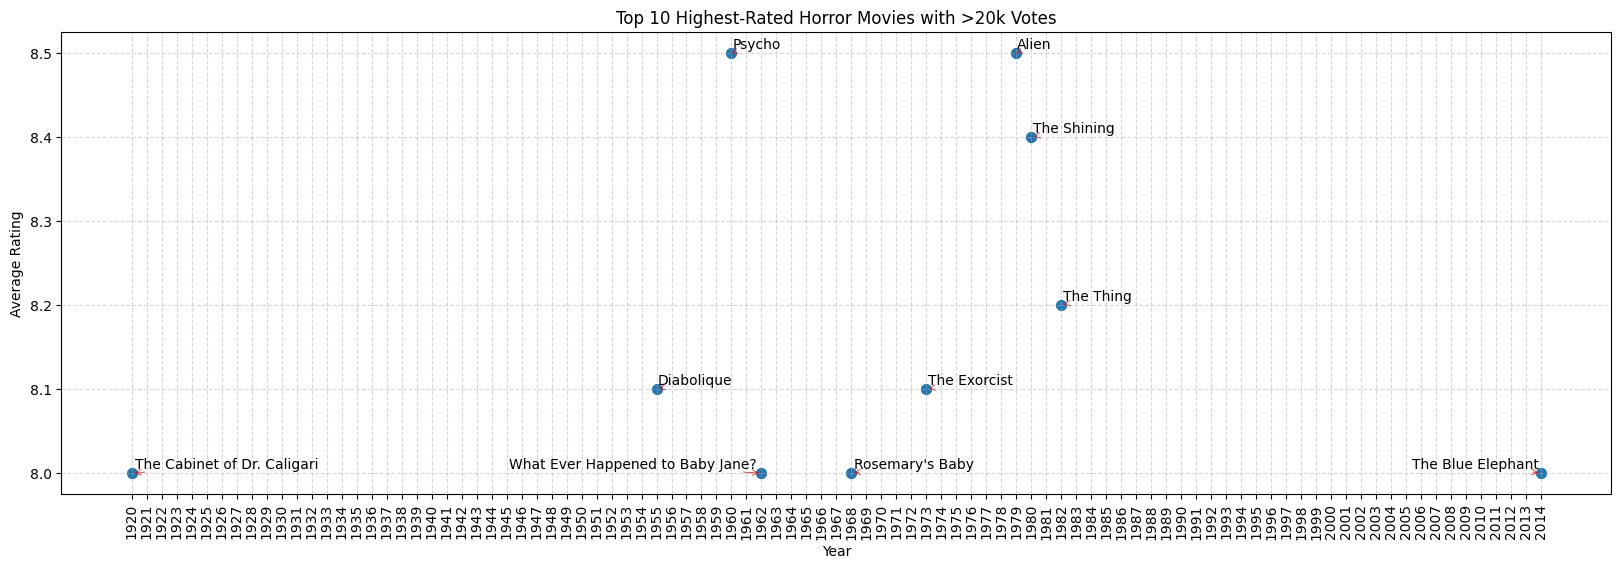

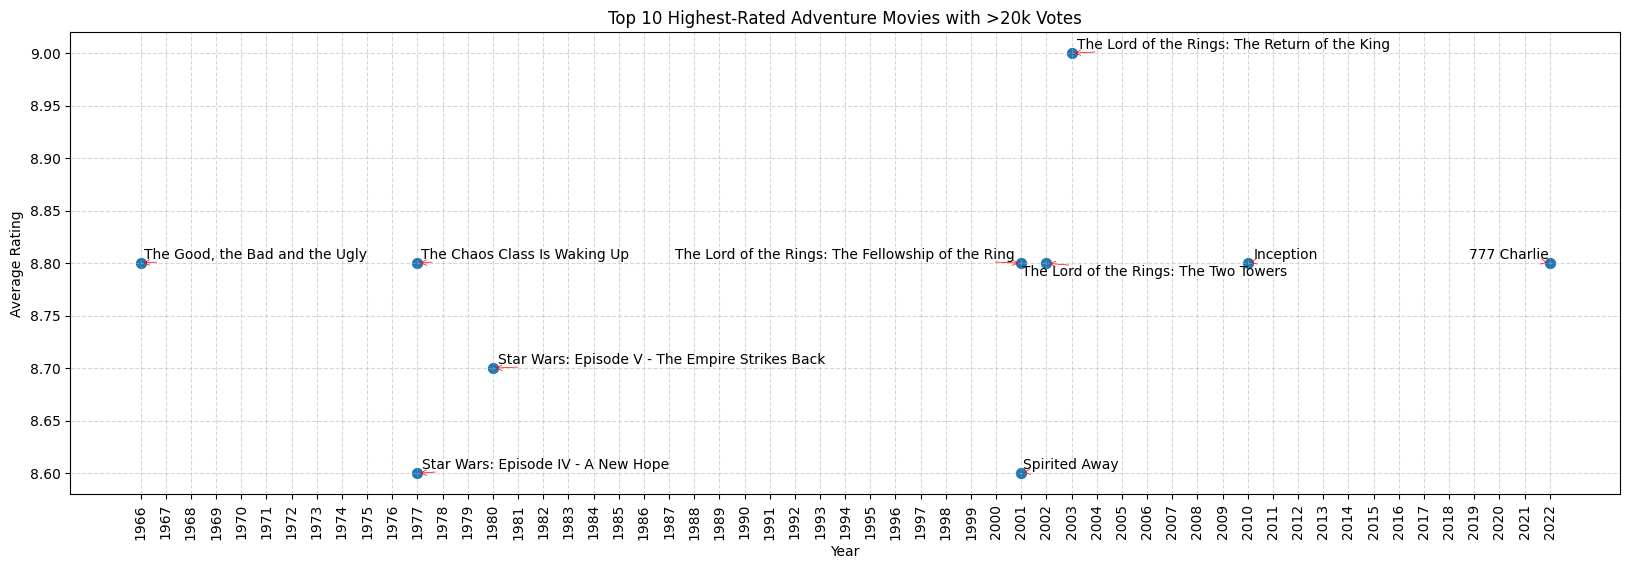

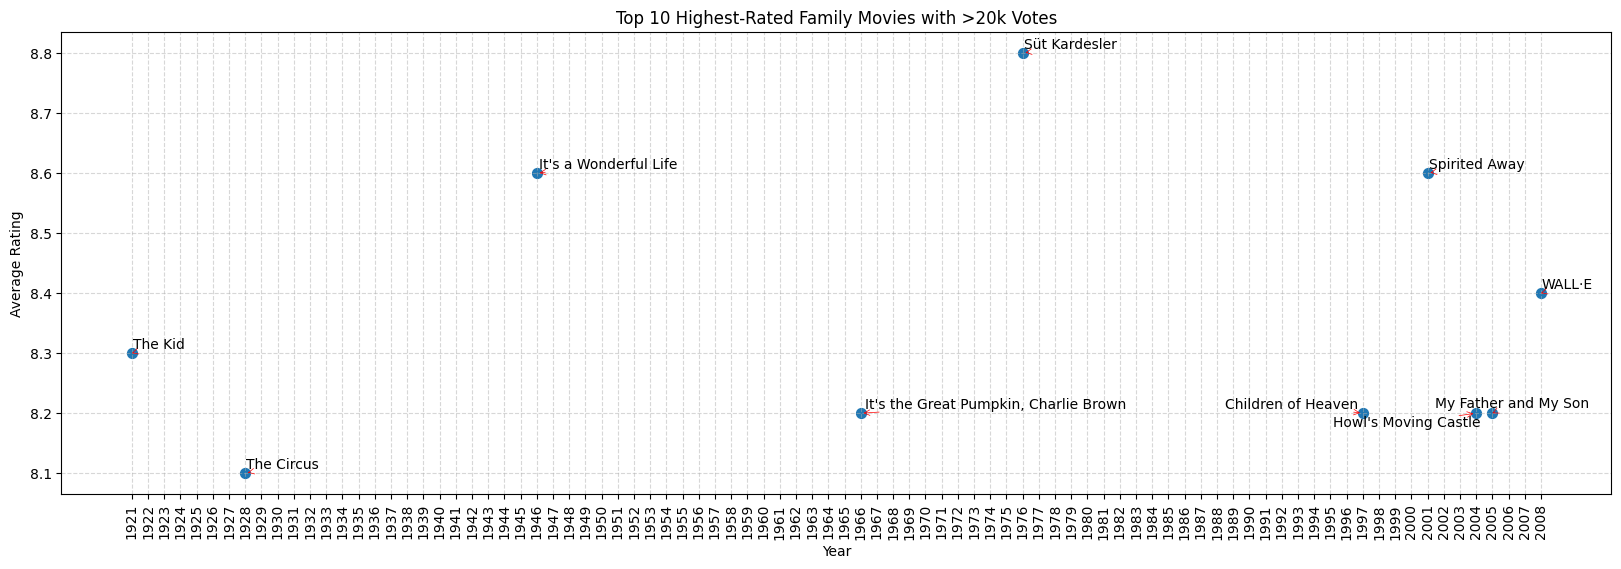

In [121]:
# Lets find higest rated movies for each genre with more than 20k votes

from adjustText import adjust_text


movies_high_votes = movies_df_encoded[movies_df_encoded['numVotes'] > 20000]
top_10_movies_each_genre = []

for genre in top_10_genres:
    movies_by_genre = movies_high_votes[movies_high_votes[f'genre_{genre}'] == 1]
    top_10_movies = movies_by_genre.nlargest(10, 'averageRating')[['primaryTitle', 'originalTitle', 'startYear', 'averageRating', 'numVotes', 'primaryName']]
    top_10_movies['genre'] = genre
    top_10_movies_each_genre.append(top_10_movies)

result = pd.concat(top_10_movies_each_genre, ignore_index=True)

for genre in top_10_genres:
    # Filter the result DataFrame by genre
    genre_data = result[result['genre'] == genre]
    
    genre_data['startYear'] = genre_data['startYear'].astype(int)
    
    genre_data = genre_data.sort_values('startYear')
    
    
    plt.figure(figsize=(20, 6))
    plt.scatter(genre_data['startYear'], genre_data['averageRating'], s=50)
    
    texts = []
    for index, row in genre_data.iterrows():
        texts.append(plt.text(row['startYear'], row['averageRating'], row['primaryTitle'], fontsize=10, ha='left', va='bottom'))
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))
    
    # Set the title and labels
    plt.title(f'Top 10 Highest-Rated {genre} Movies with >20k Votes')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    
    min_year = genre_data['startYear'].min()
    max_year = genre_data['startYear'].max()
    years = np.arange(min_year, max_year + 1, 1)
    
    # Set the x-axis ticks and labels
    plt.xticks(years, rotation=90)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    # Show the plot
    plt.show()

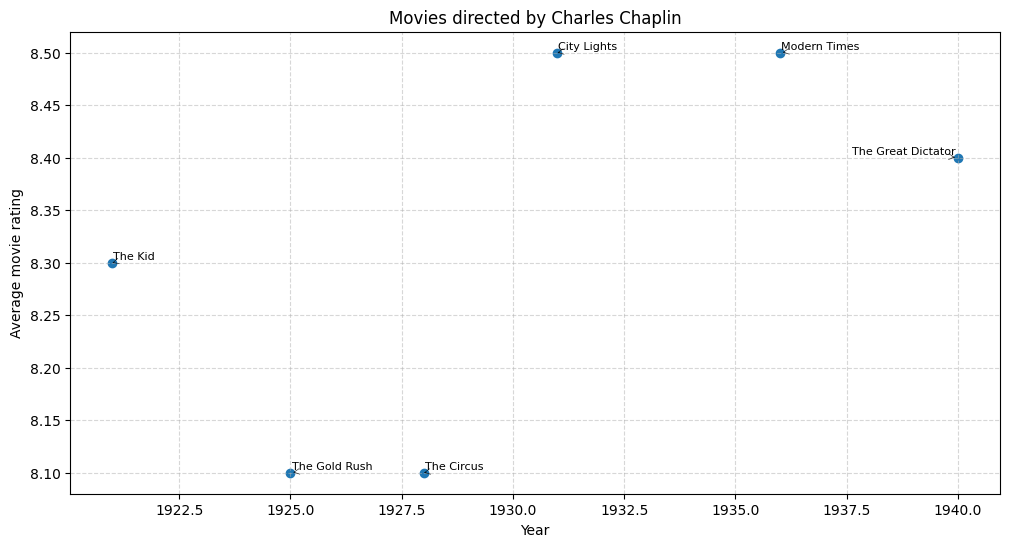

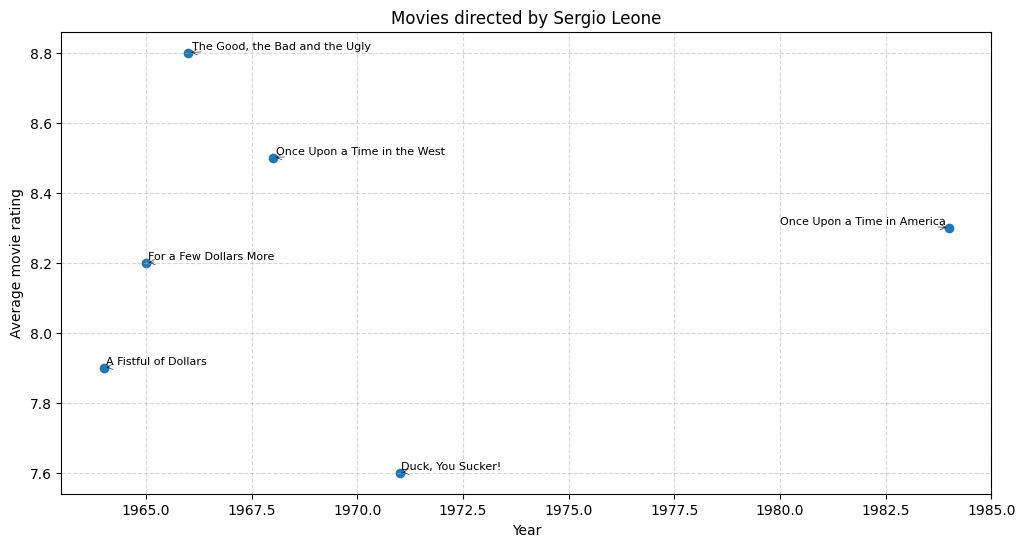

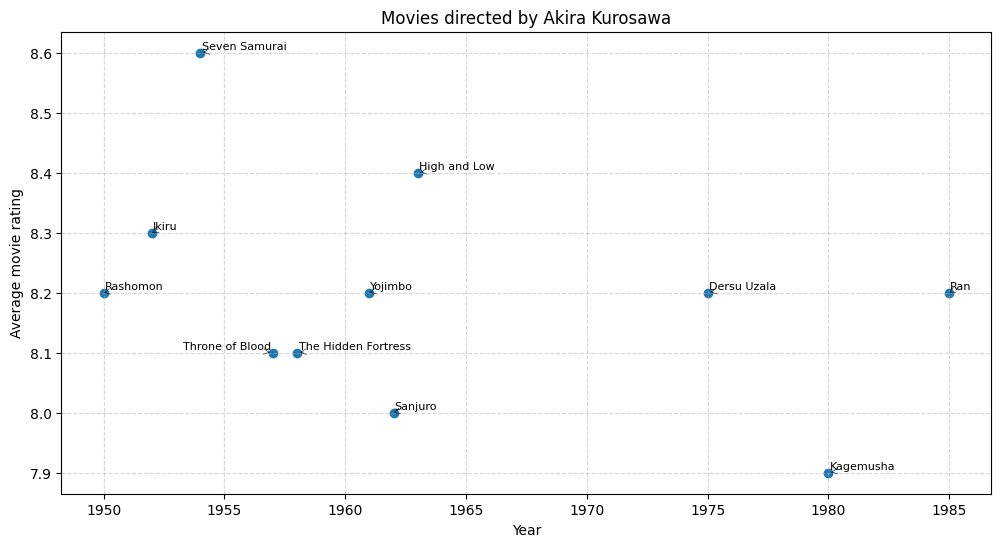

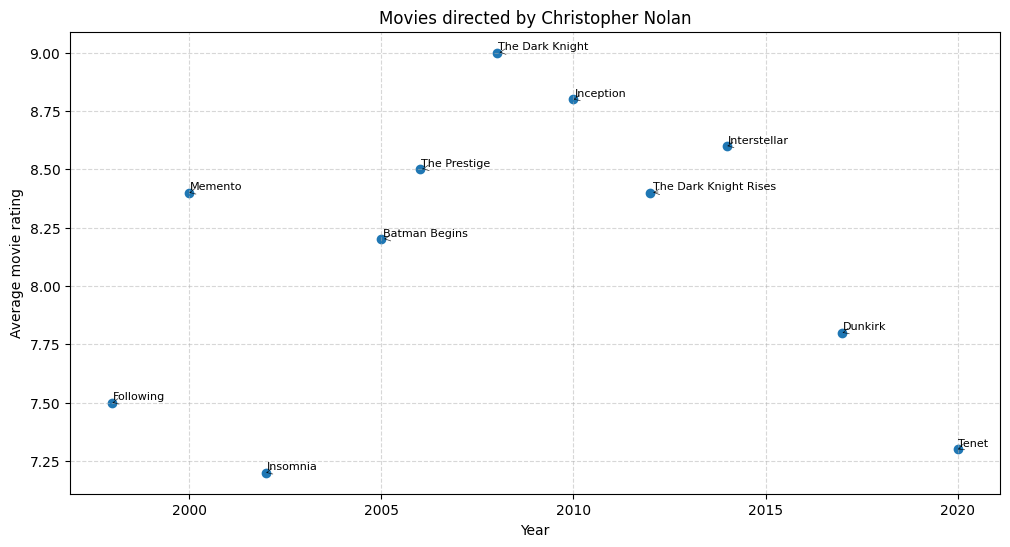

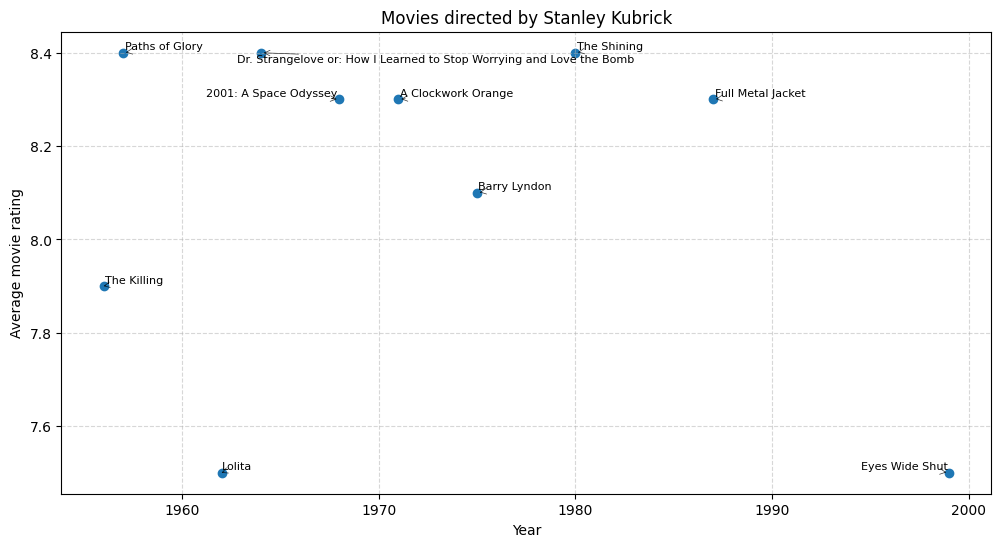

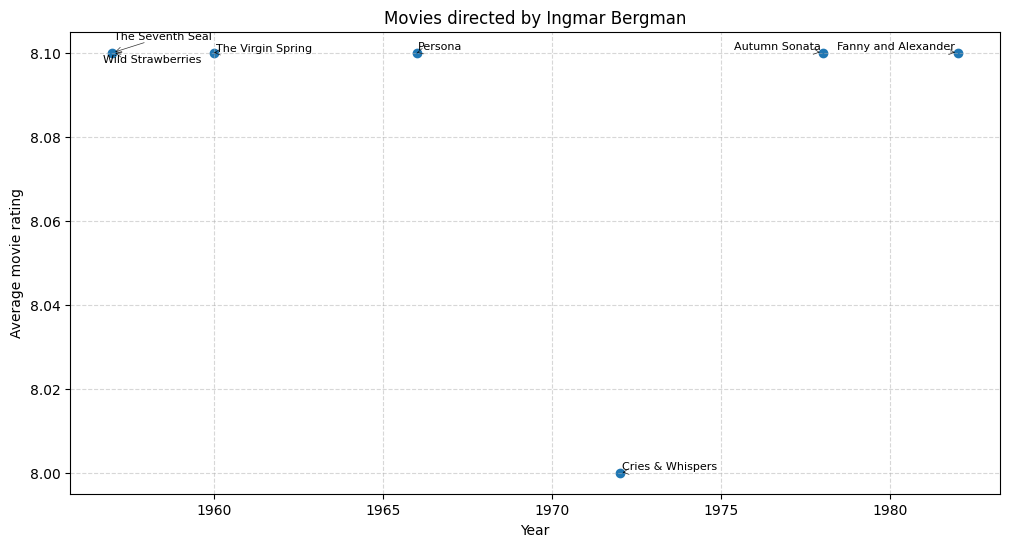

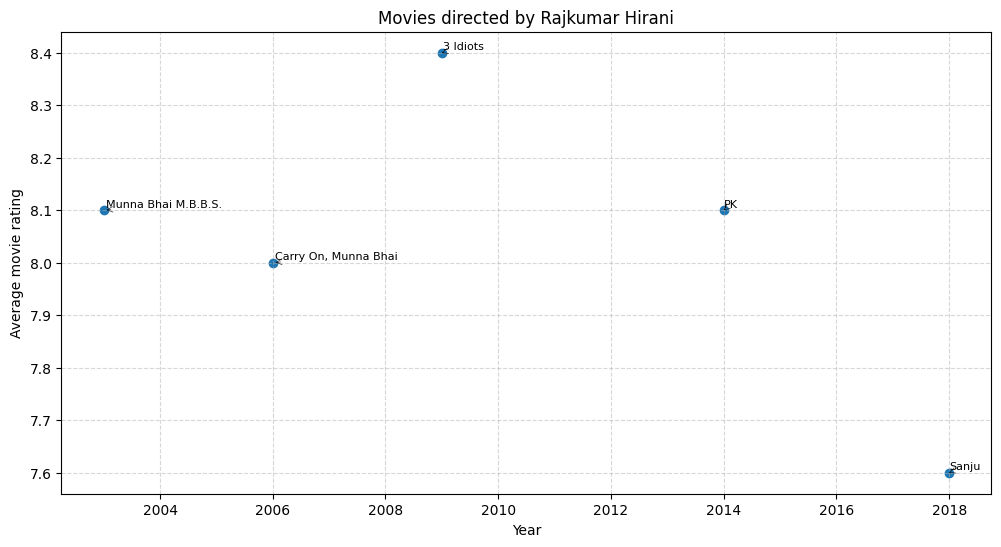

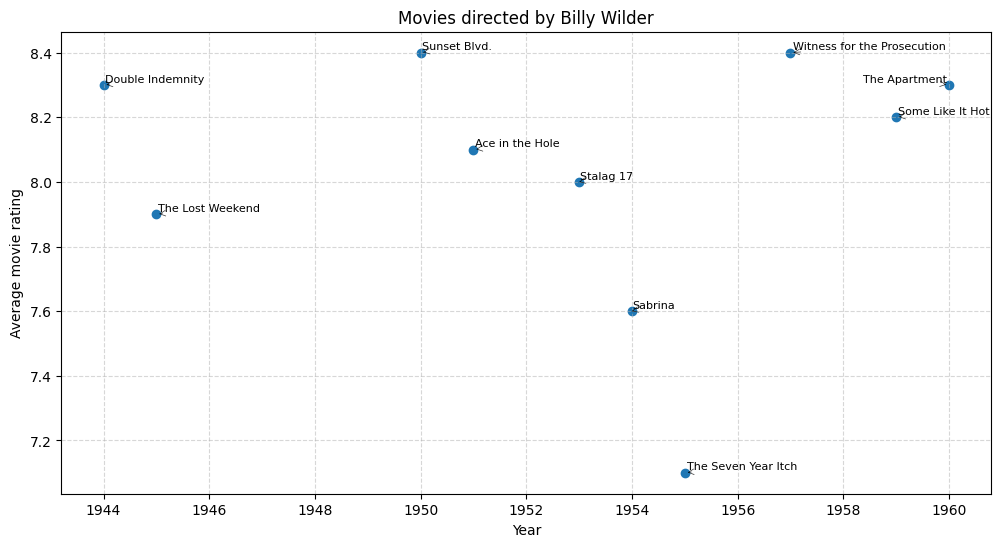

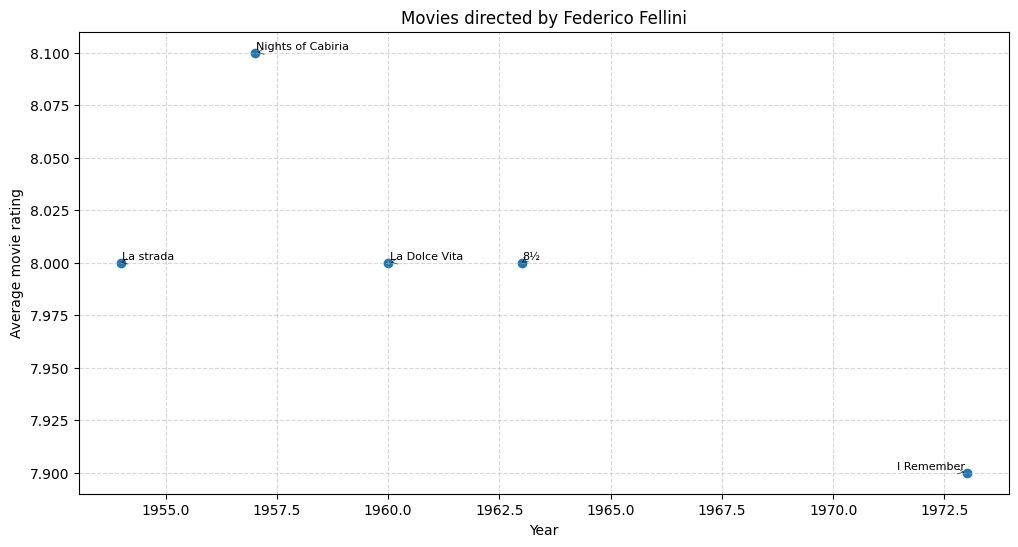

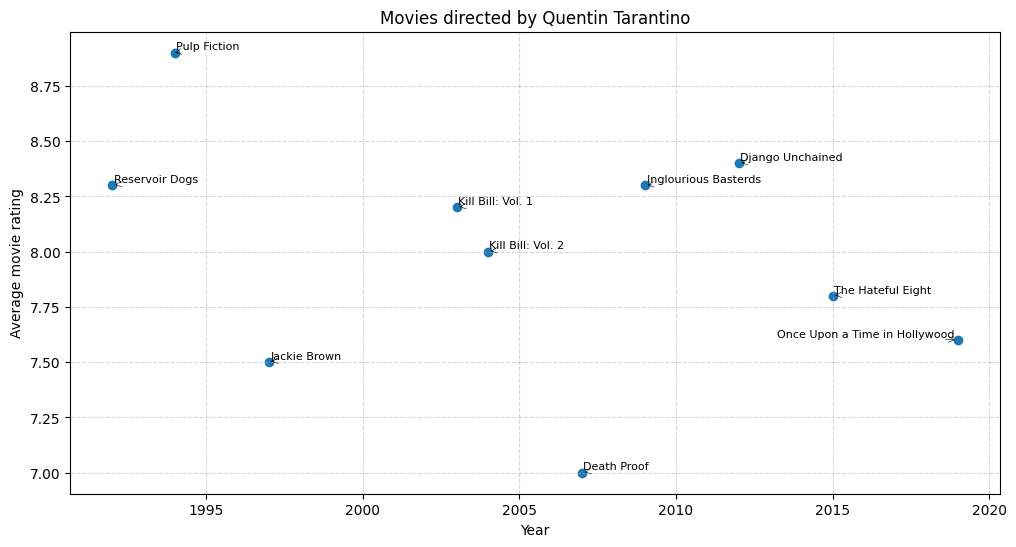

In [170]:
# Filter the movies with a minimum of 30,000 votes
filtered_data = movies_df_encoded[movies_df_encoded['numVotes'] >= 30000].copy()

# Convert 'startYear' column to float
filtered_data['startYear'] = filtered_data['startYear'].astype(float)

# Drop rows with null values in 'averageRating' or 'startYear'
filtered_data = filtered_data.dropna(subset=['averageRating', 'startYear'])

# Group the data by director and calculate the average rating and the number of movies for each director
director_stats = filtered_data.groupby('primaryName').agg({'averageRating': 'mean', 'primaryTitle': 'count'})

# Filter directors with at least 5 movies
directors_with_min_movies = director_stats[director_stats['primaryTitle'] >= 5]

# Sort the directors by their average rating in descending order and get the top 10
top_10_directors = directors_with_min_movies.sort_values(by='averageRating', ascending=False).head(10)

# Create a separate plot for each director
for director in top_10_directors.index:
    if director in filtered_data['primaryName'].unique():
        # Get the average movie ratings for the director in each year
        director_ratings = filtered_data[filtered_data['primaryName'] == director].groupby('startYear')['averageRating'].mean()

        # Create a new plot
        fig, ax = plt.subplots(figsize=(12,6))
        ax.scatter(director_ratings.index, director_ratings.values)

        # Add the movie titles to the plot
        movies = filtered_data[filtered_data['primaryName'] == director][['primaryTitle', 'startYear', 'averageRating']]
        texts = []
        for movie in movies.itertuples():
            text = ax.text(movie.startYear, movie.averageRating, movie.primaryTitle, ha='left', va='bottom', fontsize=8)
            texts.append(text)
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5, alpha=0.8))

        # Set the plot title and axis labels
        ax.set_title(f"Movies directed by {director}")
        ax.set_xlabel('Year')
        ax.set_ylabel('Average movie rating')
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.show()